<a href="https://colab.research.google.com/github/SRIKARREDDY-dotorg/Hand-Written-hindi-script-recognition/blob/master/Bajajsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bajaj Finance

In [ ]:
import yfinance as yf
import finta as TA
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
from datetime import timedelta

In [ ]:
TIMEFRAME = '5m'
symbol = 'BAJFINANCE.NS'
df = yf.download(symbol, period='60d', interval= TIMEFRAME)
df.columns = ['open','high','low','close','Adj Close','volume']

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.tail()

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2021-03-15 15:05:00+05:30,5445.000000,5459.850098,5435.000000,5445.049805,5445.049805,57678
2021-03-15 15:10:00+05:30,5447.600098,5447.700195,5428.000000,5432.000000,5432.000000,41136
2021-03-15 15:15:00+05:30,5430.049805,5447.500000,5426.100098,5431.149902,5431.149902,52640
2021-03-15 15:20:00+05:30,5431.100098,5440.500000,5424.049805,5425.399902,5425.399902,35581
2021-03-15 15:25:00+05:30,5425.350098,5426.850098,5420.000000,5420.149902,5420.149902,23344


In [ ]:
df.to_csv("bjj.csv")

In [ ]:
def maru_bozu(data_ICICI):    
    """returns dataframe with maru bozu candle column"""
    df = data_ICICI.copy()
    avg_candle_size = abs(df["close"] - df["open"]).median()
    df["h-c"] = df["high"]-df["close"]
    df["l-o"] = df["low"]-df["open"]
    df["h-o"] = df["high"]-df["open"]
    df["l-c"] = df["low"]-df["close"]
    df["maru_bozu"] = np.where((df["close"] - df["open"] > 2*avg_candle_size) & \
                               (df[["h-c","l-o"]].max(axis=1) < 0.005*avg_candle_size),"maru_bozu_green",
                               np.where((df["open"] - df["close"] > 2*avg_candle_size) & \
                               (abs(df[["h-o","l-c"]]).max(axis=1) < 0.005*avg_candle_size),"maru_bozu_red",False))
    df.drop(["h-c","l-o","h-o","l-c"],axis=1,inplace=True)
    return df


marubozu=maru_bozu(df)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
marubozu = marubozu.reset_index()

In [ ]:
marubozu.columns

Index(['Datetime', 'open', 'high', 'low', 'close', 'Adj Close', 'volume',
       'maru_bozu'],
      dtype='object')

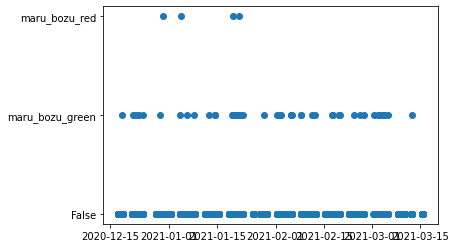

In [ ]:
plt.scatter(marubozu['Datetime'],marubozu['maru_bozu'])

In [ ]:
import backtrader,pandas
from datetime import date, datetime, time, timedelta

In [ ]:
class OpeningRangeBreakout(backtrader.Strategy):
    params = dict(
        num_opening_bars=15
    )

    def __init__(self):
        self.opening_range_low = 0
        self.opening_range_high = 0
        self.opening_range = 0
        self.bought_today = False
        self.order = None
    
    def log(self, txt, dt=None):
        if dt is None:
            dt = self.datas[0].datetime.datetime()

        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            order_details = f"{order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}"
            
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order_details}")
            else:  # Sell
                self.log(f"SELL EXECUTED, Price: {order_details}")
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        current_bar_datetime = self.data.num2date(self.data.datetime[0])
        previous_bar_datetime = self.data.num2date(self.data.datetime[-1])
        #print('current bar datetime: ',current_bar_datetime)
        #print('previous bar datetime: ',previous_bar_datetime)
        if current_bar_datetime.date() != previous_bar_datetime.date():
            self.opening_range_low = self.data.low[0]
            #print(self.data.low[0])
            self.opening_range_high = self.data.high[0]
            #print(self.data.high[0])
            self.bought_today = False
        
        opening_range_start_time = time(9, 30, 0)
        #print(opening_range_start_time)
        dt = datetime.combine(date.today(), opening_range_start_time) + timedelta(minutes=self.p.num_opening_bars)
        opening_range_end_time = dt.time()
        #print(opening_range_end_time)
        
        if current_bar_datetime.time() >= opening_range_start_time \
            and current_bar_datetime.time() < opening_range_end_time:           
            self.opening_range_high = max(self.data.high[0], self.opening_range_high)
            self.opening_range_low = min(self.data.low[0], self.opening_range_low)
            self.opening_range = self.opening_range_high - self.opening_range_low
        else:
            if self.order:
                return
            
            if self.position and (self.data.close[0] > (self.opening_range_high + self.opening_range)):
                self.close()
                
            if self.data.close[0] > self.opening_range_high and not self.position and not self.bought_today:
                self.order = self.buy()
                self.bought_today = True

            if self.position and (self.data.close[0] < (self.opening_range_high - self.opening_range)):
                self.order = self.close()

            if self.position and current_bar_datetime.time() >= time(15, 45, 0):
                self.log("RUNNING OUT OF TIME - LIQUIDATING POSITION")
                self.close()

    def stop(self):
        self.log('(Num Opening Bars %2d) Ending Value %.2f' %
                 (self.params.num_opening_bars, self.broker.getvalue()))

        if self.broker.getvalue() > 130000:
            self.log("*** BIG WINNER ***")

        if self.broker.getvalue() < 70000:
            self.log("*** MAJOR LOSER ***") 


In [ ]:
#for a single stock of bajajfinance
if __name__=='__main__':
  cerebro = backtrader.Cerebro()
  cerebro.broker.setcash(100000.0)
  cerebro.addsizer(backtrader.sizers.PercentSizer, percents=95)
  data = backtrader.feeds.PandasData(dataname=df)
  cerebro.adddata(data)
  cerebro.addstrategy(OpeningRangeBreakout)
  cerebro.run()

2020-12-17 04:20:00, BUY EXECUTED, Price: 5196.35009765625, Cost: 94996.34908378022, Comm 0.0
2020-12-17 04:25:00, SELL EXECUTED, Price: 5216.7001953125, Cost: 94996.34908378022, Comm 0.0
2020-12-23 03:55:00, BUY EXECUTED, Price: 5060.9501953125, Cost: 95362.84753370952, Comm 0.0
2020-12-29 05:20:00, SELL EXECUTED, Price: 5187.2998046875, Cost: 95362.84753370952, Comm 0.0
2020-12-30 04:15:00, BUY EXECUTED, Price: 5228.0, Cost: 97650.66352547184, Comm 0.0
2020-12-30 04:35:00, SELL EXECUTED, Price: 5262.10009765625, Cost: 97650.66352547184, Comm 0.0
2020-12-31 03:55:00, BUY EXECUTED, Price: 5367.0, Cost: 98221.17629518386, Comm 0.0
2021-01-01 09:55:00, SELL EXECUTED, Price: 5269.9501953125, Cost: 98221.17629518386, Comm 0.0
2021-01-07 04:00:00, BUY EXECUTED, Price: 5082.5, Cost: 96582.37623020627, Comm 0.0
2021-01-08 04:15:00, SELL EXECUTED, Price: 5073.25, Cost: 96582.37623020627, Comm 0.0
2021-01-08 06:50:00, BUY EXECUTED, Price: 5132.39990234375, Cost: 96373.48769825105, Comm 0.0
2021

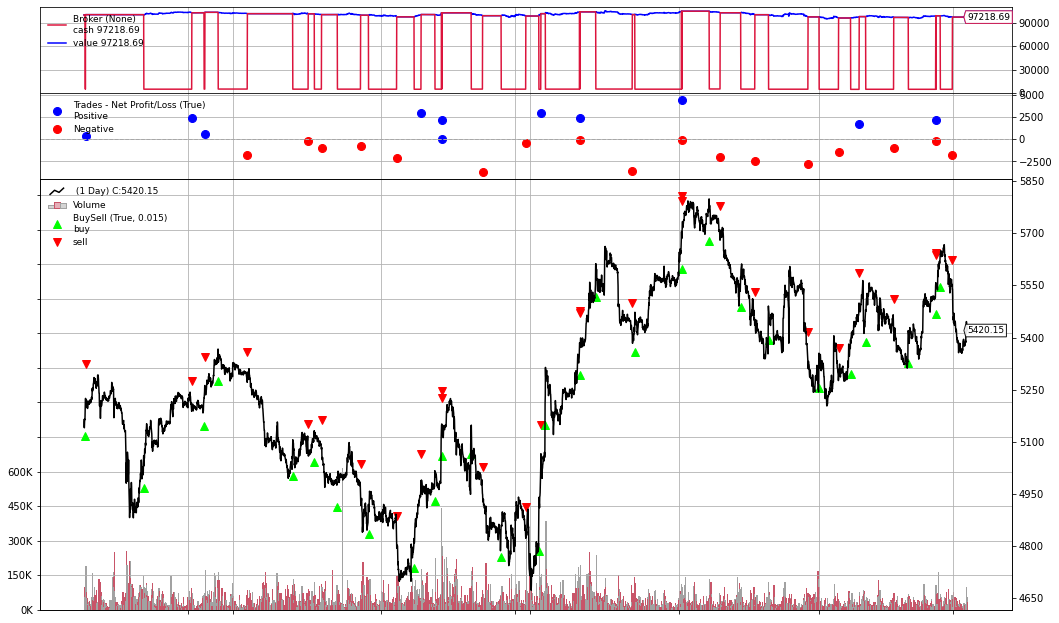

[[<Figure size 1080x648 with 4 Axes>]]

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize']=[15, 9]
cerebro.plot(iplot=False)

In [ ]:
# symbol = BANKBARODA

In [1]:
!pip install yfinance
!pip install finta
!pip install backtrader

# Bank of Baroda

In [2]:
import yfinance as yf
import finta as TA
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
from datetime import timedelta
import backtrader,pandas
from datetime import date, datetime, time, timedelta

In [12]:
'''TIMEFRAME = '5m'
symbol = 'MINDTREE.NS'
df = yf.download(symbol, period='5d', interval= TIMEFRAME)
df.columns = ['open','high','low','close','Adj Close','volume']'''

[*********************100%***********************]  1 of 1 completed


In [6]:
import os
for files in os.listdir('/content/drive/MyDrive/kaggle/FullDataCsv'):
  print(files)
  df = pd.read_csv('/content/drive/MyDrive/kaggle/FullDataCsv'+'/'+files)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df=df.set_index('timestamp')
  df = df.dropna()
  buy_factor = 3.5
  cerebro = backtrader.Cerebro()
  cerebro.broker.setcash(100000.0)
  cerebro.addsizer(backtrader.sizers.PercentSizer, percents=95)
  data = backtrader.feeds.PandasData(dataname=df)
  cerebro.adddata(data)
  cerebro.addstrategy(OpeningRangeBreakout)
  cerebro.run()

AARTIIND__EQ__NSE__NSE__MINUTE.csv
2017-12-22 08:06:00, BUY EXECUTED, Price: 561.95, Cost: 95000.0, Comm 0.0
2017-12-22 08:26:00, SELL EXECUTED, Price: 567.0, Cost: 95000.0, Comm 0.0
2021-01-01 09:59:00, (Num Opening Bars 15) Ending Value 100853.72
ABFRL__EQ__NSE__NSE__MINUTE.csv
2021-01-01 09:59:00, (Num Opening Bars 15) Ending Value 100000.00
ABCAPITAL__EQ__NSE__NSE__MINUTE.csv
2017-09-07 04:01:00, BUY EXECUTED, Price: 200.0, Cost: 95000.0, Comm 0.0
2017-09-07 04:02:00, SELL EXECUTED, Price: 203.25, Cost: 95000.0, Comm 0.0
2018-08-30 04:14:00, BUY EXECUTED, Price: 143.6, Cost: 96466.5625, Comm 0.0
2018-08-30 06:18:00, SELL EXECUTED, Price: 141.4, Cost: 96466.5625, Comm 0.0
2021-01-01 09:59:00, (Num Opening Bars 15) Ending Value 100065.85
ADANIENT__EQ__NSE__NSE__MINUTE.csv
2018-01-03 04:08:00, BUY EXECUTED, Price: 174.2, Cost: 94891.05504587154, Comm 0.0
2018-01-03 05:58:00, SELL EXECUTED, Price: 176.25, Cost: 94891.05504587154, Comm 0.0
2019-05-20 05:30:00, BUY EXECUTED, Price: 138.8

KeyError: ignored

In [51]:
df = pd.read_csv("/content/drive/MyDrive/kaggle/FullDataCsv/ABFRL__EQ__NSE__NSE__MINUTE.csv")

In [52]:
df.head()

,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,138.50,138.65,138.5,138.50,450.0
1,2017-01-02 09:16:00+05:30,138.50,138.50,138.2,138.20,152.0
2,2017-01-02 09:17:00+05:30,138.20,138.25,138.2,138.25,150.0
3,2017-01-02 09:18:00+05:30,138.25,138.40,138.2,138.20,193.0
4,2017-01-02 09:19:00+05:30,138.05,138.10,138.0,138.00,694.0


In [53]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [54]:
df.dtypes

timestamp    datetime64[ns, pytz.FixedOffset(330)]
open                                       float64
high                                       float64
low                                        float64
close                                      float64
volume                                     float64
dtype: object

In [55]:
df=df.set_index('timestamp')

In [56]:
df.isna().sum()

open      364
high      364
low       364
close     364
volume    364
dtype: int64

In [57]:
df.shape

(370540, 5)

In [58]:
df = df.dropna()

In [59]:
buy_factor=float(input())

3.5


In [5]:
class OpeningRangeBreakout(backtrader.Strategy):
    params = dict(
        num_opening_bars=15
    )

    def __init__(self):
        self.opening_range_low = 0
        self.opening_range_high = 0
        self.opening_range = 0
        self.bought_today = False
        self.order = None
        self.Todaylastvolume=0
        self.Todayfirstvolume=0
        self.Yesterdaylastvolume=0
    def log(self, txt, dt=None):
        if dt is None:
            dt = self.datas[0].datetime.datetime()

        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            order_details = f"{order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}"
            
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order_details}")
            else:  # Sell
                self.log(f"SELL EXECUTED, Price: {order_details}")
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        current_bar_datetime = self.data.num2date(self.data.datetime[0])
        previous_bar_datetime = self.data.num2date(self.data.datetime[-1])
        #print('current bar datetime: ',current_bar_datetime)
        #print('previous bar datetime: ',previous_bar_datetime)
        if current_bar_datetime.date() != previous_bar_datetime.date():
            self.opening_range_low = self.data.low[0]
            #print(self.data.low[0])
            self.opening_range_high = self.data.high[0]
            #print(self.data.high[0])
            self.bought_today = False
            #print("Today first volume",self.Todayfirstvolume)
            #print("Today last volume",self.Todaylastvolume)
            #print("current datetime",current_bar_datetime.date())
            self.Yesterdaylastvolume=self.Todaylastvolume
            self.Todayfirstvolume=0
            self.Todaylastvolume=0
        
        opening_range_start_time = time(9, 15, 0)
        dt = datetime.combine(date.today(), opening_range_start_time) + timedelta(minutes=self.p.num_opening_bars)
        opening_range_end_time = dt.time()
        test_range_start_time = time(14,15,0)
        dt = datetime.combine(date.today(), test_range_start_time) + timedelta(minutes=75)
        test_range_end_time = dt.time()
        currentdatetime = datetime.combine(current_bar_datetime.date(), current_bar_datetime.time()) + timedelta(minutes=330)
        #print(currentdatetime.time())
        if currentdatetime.time() >= opening_range_start_time and currentdatetime.time() < opening_range_end_time:           
            self.opening_range_high = max(self.data.high[0], self.opening_range_high)
            self.opening_range_low = min(self.data.low[0], self.opening_range_low)
            self.opening_range = self.opening_range_high - self.opening_range_low
            self.Todayfirstvolume+=self.data.volume[0]
            #print("within 15 mins",self.data.volume[0],currentdatetime.time())
        else:
            #print(self.data.volume[0],self.data.num2date(self.data.datetime[0]))
            if currentdatetime.time() >= test_range_start_time and currentdatetime.time() < test_range_end_time:
                self.Todaylastvolume+=self.data.volume[0]
            
            #print("outside 15 mins",self.data.volume[0],currentdatetime.time())
            if self.order:
                return
            
            if self.position and (self.data.close[0] > (self.opening_range_high*1.01)):
                self.close()
                
            if self.Todayfirstvolume>(self.Yesterdaylastvolume*buy_factor):
                if self.data.close[0] > self.opening_range_high and not self.position and not self.bought_today and self.Yesterdaylastvolume : 
                    self.order = self.buy()
                    self.bought_today = True
                

                if self.position and (self.data.close[0] < (self.opening_range_low)):
                    self.order = self.close()
            

            if self.position and current_bar_datetime.time() >= time(15, 45, 0):
                self.log("RUNNING OUT OF TIME - LIQUIDATING POSITION")
                self.close()

    def stop(self):
        #print("current datetime",current_bar_datetime.date())
        #print("Today first volume",self.Todayfirstvolume)
        #print("Today last volume",self.Todaylastvolume)
        self.log('(Num Opening Bars %2d) Ending Value %.2f' %
                 (self.params.num_opening_bars, self.broker.getvalue()))

        if self.broker.getvalue() > 130000:
            self.log("*** BIG WINNER ***")

        if self.broker.getvalue() < 70000:
            self.log("*** MAJOR LOSER ***") 


In [61]:
#for a single stock of bajajfinance
if __name__=='__main__':
  cerebro = backtrader.Cerebro()
  cerebro.broker.setcash(100000.0)
  cerebro.addsizer(backtrader.sizers.PercentSizer, percents=95)
  data = backtrader.feeds.PandasData(dataname=df)
  cerebro.adddata(data)
  cerebro.addstrategy(OpeningRangeBreakout)
  cerebro.run()

Today first volume 0
Today last volume 0
current datetime 2017-01-02
Today first volume 4525.0
Today last volume 28895.0
current datetime 2017-01-03
Today first volume 3039.0
Today last volume 24835.0
current datetime 2017-01-04
Today first volume 7883.0
Today last volume 92864.0
current datetime 2017-01-05
Today first volume 18479.0
Today last volume 55847.0
current datetime 2017-01-06
Today first volume 7017.0
Today last volume 37218.0
current datetime 2017-01-09
Today first volume 2268.0
Today last volume 30956.0
current datetime 2017-01-10
Today first volume 9512.0
Today last volume 108187.0
current datetime 2017-01-11
Today first volume 7387.0
Today last volume 80534.0
current datetime 2017-01-12
Today first volume 38387.0
Today last volume 33597.0
current datetime 2017-01-13
Today first volume 39708.0
Today last volume 83273.0
current datetime 2017-01-16
Today first volume 20757.0
Today last volume 117664.0
current datetime 2017-01-17
Today first volume 58739.0
Today last volume 

In [35]:
df.to_csv("bob.csv")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/kaggle/FullDataCsv

/content/drive/MyDrive/kaggle/FullDataCsv
